In [1]:
# Utils
import os, sys, re, time, gc, types, string, unicodedata, unidecode, string, warnings, inspect

import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
import time
import pickle

from sklearn.metrics import accuracy_score
from IPython.display import display, Markdown, Latex

import shutil

from tensorflow.contrib.learn import DNNClassifier
import scikitplot as skplt

import scipy
#plt.style.use('fivethirtyeight')

# Parameters

In [2]:
root_path = "../"
path_model = root_path + 'models/test'
features_path = root_path + 'data/features/data_tfid_hash28_n1000_SVD2.p'
#features_path = root_path + 'data/features/data_tfid_hash28_n10000_bigram_svd1000.p'
#features_path = root_path + 'data/features/data_tfid_hash28_n1000.p'



# Load Data

### Output

In [3]:
X ,y1 ,y2 , y3 = pickle.load( open( features_path, "rb" ) )


In [4]:
train_fraction = 0.8

y1 = y1.values    

np.random.seed(42)
train_indices = np.random.choice(X.shape[0], round(train_fraction*X.shape[0]), replace=False)
test_indices = np.array(list(set(range(X.shape[0])) - set(train_indices)))

X_train = X[train_indices]
y_train = y1[train_indices]
X_test = X[test_indices]
y_test = y1[test_indices]

In [5]:
labels = list(set(y_train))
labels.sort()
nClasses = len(labels)

def calcWeights(y):
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([float(len(y_train))/(sizes[label]*nClasses) for label in y]) #n_samples / (n_classes * np.bincount(y))
    weights = np.power(weights,1) # 1.4
    return weights 

def calcWeightsL(y):
    #lerko
    scale_factor = 10e3
    sizes = {label: y_train[y_train == label].shape[0] for label in labels}
    weights = np.asarray([scale_factor/sizes[label] for label in y])
    return weights 

weights_train = calcWeights(y_train)
weights_test = calcWeights(y_test)

# Model

### DNN graph generation

In [6]:
epochs = 14000

if isinstance(X_train, scipy.sparse.csr.csr_matrix):
    X_train = X_train.todense()
    X_test = X_test.todense()

# Define the test inputs
def get_train_inputs():    
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_train,'class_weights': weights_train},
                                                  y_train[:,np.newaxis],
                                                  shuffle=True,
                                                  batch_size=50,
                                                  num_epochs=epochs)
    return dataset

def get_test_inputs():
    dataset = tf.estimator.inputs.numpy_input_fn({'x': X_test,'class_weights': weights_test},
                                                  y_test[:,np.newaxis],
                                                  shuffle=False)
    return dataset

### functions graph tensorflow

In [7]:



feature_columns = [tf.contrib.layers.real_valued_column('x', dimension=X_train.shape[1])]

optimizer = tf.train.ProximalAdagradOptimizer(
                              learning_rate=10.0,
                              l1_regularization_strength= 0.0#0.0001
                              )

classifier = DNNClassifier(                                
                           n_classes=len(labels), label_keys=labels, feature_columns=feature_columns,
                           hidden_units=[2000], #2000, 1000, 100
                           dropout=0.5,
                           #optimizer = optimizer,
                           weight_column_name='class_weights',
                           model_dir = path_model,
                           config = tf.contrib.learn.RunConfig(save_checkpoints_steps = 500,
                           save_checkpoints_secs = None)                           
                          )

Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.RunConfig instead.
Instructions for updating:
Please switch to tf.contrib.estimator.*_head.
Instructions for updating:
Please replace uses of any Estimator from tf.contrib.learn with an Estimator from tf.estimator.*
INFO:tensorflow:Using config: {'_task_type': None, '_task_id': 0, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7f54c74affd0>, '_master': '', '_num_ps_replicas': 0, '_num_worker_replicas': 0, '_environment': 'local', '_is_chief': True, '_evaluation_master': '', '_train_distribute': None, '_tf_config': gpu_options {
  per_process_gpu_memory_fraction: 1.0
}
, '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': None, '_log_step_count_steps': 100, '_session_config': None, '_save_checkpoints_steps': 500, '_keep_checkpoint_max': 5, '_keep_checkpoint_every_n_hours': 10000, '_model_dir': '../models/test'}


# Training



In [8]:
tf.set_random_seed(42)

delete_old_model = True
if delete_old_model:
    try:
        os.system("rm -rf "+path_model)
        os.system("mkdir "+path_model)
    except:
        print("error")
    
validation_monitor = tf.contrib.learn.monitors.ValidationMonitor(
    #input_fn= get_train_inputs(),
    input_fn= get_test_inputs(),
    
    every_n_steps=500,
    #early_stopping_metric="accuracy",
    early_stopping_metric="loss",
    early_stopping_metric_minimize=True,
    early_stopping_rounds=2500)

start = time.time()
print("start")

#classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)
classifier.fit(input_fn=get_train_inputs(), monitors=[validation_monitor], steps=epochs, max_steps=None)

end = time.time()
print("Training time :" + str(end - start) )


Instructions for updating:
Monitors are deprecated. Please use tf.train.SessionRunHook.
start
Instructions for updating:
When switching to tf.estimator.Estimator, use tf.estimator.EstimatorSpec. You can use the `estimator_spec` method to create an equivalent one.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into ../models/test/model.ckpt.
INFO:tensorflow:loss = 2.4630566, step = 0
INFO:tensorflow:global_step/sec: 259.705
INFO:tensorflow:loss = 1.7395217, step = 100 (0.386 sec)
INFO:tensorflow:global_step/sec: 311.76
INFO:tensorflow:loss = 1.6139877, step = 200 (0.321 sec)
INFO:tensorflow:global_step/sec: 309.622
INFO:tensorflow:loss = 1.6813898, step = 300 (0.323 sec)
INFO:tensorflow:global_step/sec: 301.878
INFO:tensorflow:loss = 1.3151793, step = 400 (0.333 sec)
INFO:tensorflow:Saving checkpoints for 501 into ../models/test/mo

INFO:tensorflow:global_step/sec: 315.605
INFO:tensorflow:loss = 0.72242683, step = 4700 (0.317 sec)
INFO:tensorflow:global_step/sec: 307.409
INFO:tensorflow:loss = 0.19202517, step = 4800 (0.327 sec)
INFO:tensorflow:global_step/sec: 317.012
INFO:tensorflow:loss = 0.6260061, step = 4900 (0.314 sec)
INFO:tensorflow:Saving checkpoints for 5001 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 261.141
INFO:tensorflow:Starting evaluation at 2018-10-08-17:50:29
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-5001
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-10-08-17:50:30
INFO:tensorflow:Saving dict for global step 5001: accuracy = 0.83255774, global_step = 5001, loss = 0.4910861
INFO:tensorflow:Validation (step 5000): loss = 0.4910861, accuracy = 0.83255774, global_step = 5001
INFO:tensorflow:loss = 0.15942708, step = 5000 (1.779 sec)
INFO

INFO:tensorflow:global_step/sec: 308.319
INFO:tensorflow:loss = 0.5027505, step = 9800 (0.323 sec)
INFO:tensorflow:global_step/sec: 301.798
INFO:tensorflow:loss = 0.82288504, step = 9900 (0.331 sec)
INFO:tensorflow:Saving checkpoints for 10001 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 251.225
INFO:tensorflow:loss = 0.8081485, step = 10000 (0.399 sec)
INFO:tensorflow:global_step/sec: 304.09
INFO:tensorflow:loss = 0.5510831, step = 10100 (0.330 sec)
INFO:tensorflow:global_step/sec: 300.012
INFO:tensorflow:loss = 0.30107915, step = 10200 (0.333 sec)
INFO:tensorflow:global_step/sec: 312.1
INFO:tensorflow:loss = 0.4721387, step = 10300 (0.319 sec)
INFO:tensorflow:global_step/sec: 304.132
INFO:tensorflow:loss = 0.9152418, step = 10400 (0.329 sec)
INFO:tensorflow:Saving checkpoints for 10501 into ../models/test/model.ckpt.
INFO:tensorflow:global_step/sec: 249.635
INFO:tensorflow:loss = 0.4442324, step = 10500 (0.400 sec)
INFO:tensorflow:global_step/sec: 319.974
INFO:ten

# Evaluation performance


INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


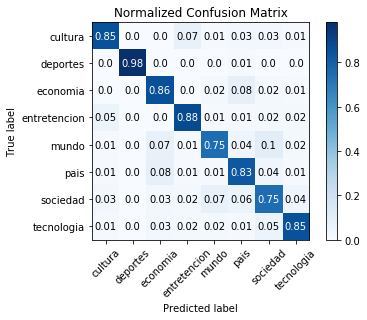

## Accuracy in test: 87.30633950255422 

In [9]:
#X_test = X_test.todense().p'

def input_fn_evaluate():
    dataset = {'x': tf.constant(X_test )}    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)
y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)


acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
plt.xticks(rotation=45)
plt.show()

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from ../models/test/model.ckpt-14000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.


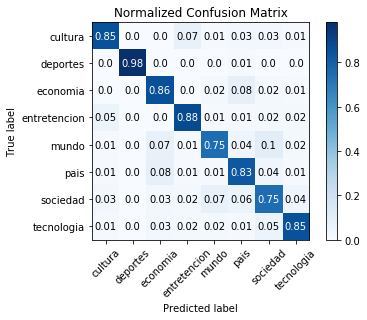

## Accuracy in test: 87.30633950255422 

In [10]:
#X_test = X_test.todense()

def input_fn_evaluate():
    dataset = {'x': tf.constant(X_test )}    
    return dataset

pred_test = classifier.predict_classes(input_fn=input_fn_evaluate)
y_test_hat = np.asarray([x.decode('UTF-8') for x in list(pred_test)])
y_test_hat = y_test_hat.astype(str)


acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
plt.xticks(rotation=45)
plt.show()

#print('Accuracy in test: {}'.format(acc))
display(Markdown('## Accuracy in test: {} '.format(acc*100)))

In [11]:
# def input_fn_evaluate1():
#     dataset = {'x': tf.constant(X_test[0:25000,:].todense() )}    
#     return dataset

# pred_test1 = classifier.predict_classes(input_fn=input_fn_evaluate1)

# def input_fn_evaluate2():
#     dataset = {'x': tf.constant(X_test[25000:,:].todense() )}    
#     return dataset
# pred_test2 = classifier.predict_classes(input_fn=input_fn_evaluate2)


In [12]:
# y_test_hat1 = np.asarray([x.decode('UTF-8') for x in list(pred_test1)])
# y_test_hat2 = np.asarray([x.decode('UTF-8') for x in list(pred_test2)])
# y_test_hat = np.concatenate((y_test_hat1, y_test_hat2), axis=0)

In [ ]:

» Ahumada4
» Agustinas0
» Cantagallo19
» Las Condes5
» Los Leones0
» Manuel Montt13
» Mall Arauco Maipú12
» Mall Costanera Center3


In [13]:

# y_test_hat = y_test_hat.astype(str)


# acc = accuracy_score(y_true=y_test, y_pred=y_test_hat)

# skplt.metrics.plot_confusion_matrix(y_test, y_test_hat,normalize='True')
# plt.xticks(rotation=45)
# plt.show()

# #print('Accuracy in test: {}'.format(acc))
# display(Markdown('## Accuracy in test: {} '.format(acc*100)))